In [2]:
import nltk
nltk.download('words')
from nltk.corpus import words
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from nltk.tokenize import MWETokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter

In [4]:
import numpy as np
import tqdm
import pandas as pd
import pathlib
import os
import re
import string
import time
from random import random
from collections import defaultdict
from typing import List, Union
import pprint
import json
import tensorflow as tf
from gensim.models import Word2Vec
from time import time

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#### Mount to Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

product_reviews_dir = 'product_reviews'
drive_path = "/content/drive" + "/My Drive/Colab Notebooks/" + product_reviews_dir
files = os.listdir(drive_path)

Mounted at /content/drive


In [71]:
def read_data(path: str) -> List[str]:
    """
        Read files from a directory and then append the data of each file into a list.
    :param path:
    :return:
    """
    files = os.listdir(path)  # to be iterated over in folder
    content = ""  # to store the contents of each file in folder
    files.remove('README.txt')
    for filename in files:
        file_path = f'{path}/{filename}'
        file_extension = pathlib.Path(file_path).suffix
        if '.txt' == file_extension:  # ensure we only read from *.txt files
            with open(file_path, encoding='utf8') as f_open:
                content_lines = f_open.read()  # grab the contents of the file
            content += content_lines
    return content

In [72]:
def clean_document(document: str) -> str:
    """
        Perform text and character removal
    """
    # Normalize text by converting to lower case to minimise query time, computational and memory costs
    document = document.lower()
    # Remove redundant characters directly with custom regex to ease tokenization
    reg_to_drop = r'''(?x)           # flag to allow comments and multi-line regex
              | \( | \)              # remove ()-brackets as their contents can be useful
              | ^\$[\d,]+(\.\d*)?$   # cut out the money expressions
              | [^(!"#$%&'()*+, -.\/:;<=>?@[\]^_`{|}~) | (a-zA-Z0-9\s)]  # remove non-word, non-digit, non-punctuation characters, non-space, e.g. '•', '≠'
              | \\[u|U][a-zA-Z0-9]+  # remove codes like `\u00F4`
    '''
    reg_compiler = re.compile(reg_to_drop)
    document = reg_compiler.sub(r'', document)

    # Handle apostrophes
    document = re.sub(r"won\'t", "will not", document)
    document = re.sub(r"n\'t", " not", document)
    document = re.sub(r"\'t", " not", document)
    document = re.sub(r"\'m", " am", document)
    document = re.sub(r"\'re", " are", document)
    document = re.sub(r"\'ll", " will", document)
    document = re.sub(r"\'ve", " have", document)

    # Add extra spaces to \n and \#
    document = re.sub(r"\n", "\n ", document)
    document = re.sub(r"##", "## ", document)
    document = re.sub(r"\.\.\.", " ", document)

    # Handle shortenings
    document = re.sub(r" u ", " you ", document)
    # Transform sentiments
    document = re.sub(r"\[\+\]", "[+1]", document)
    document = re.sub(r"\[1\]", "[+1]", document)
    document = re.sub(r"\[u\]", "", document)
    document = re.sub(r"\[p\]", "", document)
    document = re.sub(r"\[s\]", "", document)
    document = re.sub(r"\[cc\]", "", document)
    document = re.sub(r"\[cs\]", "", document)

    # drop any web links
    document = re.sub(r"([^ ]+ (?<=\. [a-z] {3}))", "<url>", document)

    return document

In [73]:
def process_document(document: str, drop_punct: bool = True, drop_digits: bool = True):
    """
      Pre-process a document and return a list of its terms
    :param document:
    :return:
    """
    # Clean the data
    document = clean_document(document)

    # new lines are no longer needed as the review lines have been concatenated with a space
    document = document.replace('\n', '')

    # Apply NLTK’s recommended word tokenizer for single word expressions (swe)
    word_tokens = word_tokenize(document)

    if drop_punct:
        punc = r'''[\!\(\)\-\[\]\{\}\;\:\'\"\,\<\>\.\/\?\@\$\%\\\^\&\*\_\~\`]'''
        word_tokens = [w for w in word_tokens if not re.search(punc, w)]
        # word_tokens = [w for w in word_tokens if not w in ['.', ',', '#', 'l', '[', ']']]
    
    if drop_digits:
        digit = r'''[0-9]+'''
        word_tokens = [w for w in word_tokens if not re.search(digit, w)]

    # Remove STOP words
    stop_words = set(stopwords.words('english'))
    filtered_data = [w for w in word_tokens if not w.lower() in stop_words]

    stemmer = SnowballStemmer(language='english')
    filtered_data = [stemmer.stem(w) for w in filtered_data]

    return filtered_data

In [74]:
def parse_sentiment(sentiment_str: str, verbose: bool = False) -> int:
    sentiment_score = 0
    sentiment_regex = r'(?<=\[).+?(?=\])'
    sentiment_scores_str = re.findall(sentiment_regex, sentiment_str)
    if verbose:
        print(sentiment_scores_str)
    for s in sentiment_scores_str:
        try:
            sentiment_score += int(s)
        except ValueError:
            pass
    return sentiment_score

In [75]:
assert parse_sentiment('router[+2]') == 2
assert parse_sentiment('install[-2], router[+1]') == -1

In [76]:
def create_dataset(document: str):
    """
        Create whole dataset with labels and sentiment score per review. 
        Also, concatenate all review lines together.
    """
    dataset = []
    # One of the files omits `[t]` hence there will be different assumptions on the authorship
    REVIEW_MAX_CHAR_SIZE = 10_000  # hard-coded value based on distribution of review sizes
    
    # Iterate over each review `[t]`
    for review in document.split('[t]'):
        review_text = ""
        sentiment = 0  # UNKNOWN
        if len(review) <= REVIEW_MAX_CHAR_SIZE:
            # Iterate over each review `\n`
            for line in review.split('\n'):
                # Split sentiment from review line
                review_line_parts = line.split('##')
                # no sentiment, only review line
                if(len(review_line_parts) == 1):
                    review_text += review_line_parts[0] + ' '
                # sentiment and review line exist
                elif(len(review_line_parts) > 1):
                    sentiment += parse_sentiment(review_line_parts[0])
                    review_text += review_line_parts[1] + ' '
                else:
                    print(review_line_parts)
            # Define Positive, Neutral, Negative labels
            label = 0
            if sentiment > 0:
                label = 1
            elif sentiment < 0:
                label = -1
            review_entry = {
                'label': label,
                'sentiment_score': sentiment,
                'text': review_text
            }
            dataset.append(review_entry)
        else:  # since `[t]` is missing we will assume a review is a single line with a recorded sentiment
            # Iterate over each review `\n`
            for line in review.split('\n'):
                review_text = ""
                sentiment = 0  # UNKNOWN
                review_line_parts = line.split('##')
                # We only take the lines with sentiment and discard the rest for the faulty documents
                if(len(review_line_parts) > 1):
                    sentiment += parse_sentiment(review_line_parts[0])
                    # Define Positive, Neutral, Negative labels
                    review_text += review_line_parts[1]
                    label = 0
                    if sentiment > 0:
                        label = 1
                    elif sentiment < 0:
                        label = -1
                    review_entry = {
                        'label': label,
                        'sentiment_score': sentiment,
                        'text': review_text
                    }
                    dataset.append(review_entry)
    return dataset

In [77]:
content = read_data(drive_path)

In [78]:
content = clean_document(content)

In [79]:
dataset = create_dataset(content)

In [80]:
dataset = [entry for entry in dataset if entry['label']!=0]  # remove Neutral classes

In [81]:
for entry in dataset:
    entry['tokens'] = process_document(entry['text'])

#### Find stats about review sizes

In [82]:
dataset_df = pd.DataFrame(dataset)
dataset_df['tokens_size'] = dataset_df['tokens'].apply(lambda x: len(x))
dataset_df

,label,sentiment_score,text,tokens,tokens_size
0,1,19,this router does everything that it is suppo...,"[router, everyth, suppos, dont, realli, know, ...",86
1,-1,-7,"it's probably a fine router, but i found the...","[probabl, fine, router, found, instal, wizard,...",135
2,-1,-3,if you are buying this product and operate o...,"[buy, product, oper, mac, platform, ditch, cd,...",240
3,1,24,for an item that is not even available in be...,"[item, even, avail, best, buy, major, store, w...",236
4,1,12,i had some issues when i had enabled wep enc...,"[issu, enabl, wep, encrypt, move, wpa, iron, l...",79
...,...,...,...,...,...
582,1,3,"the ear buds that come with it look cheap, bu...","[ear, bud, come, look, cheap, sound, qualiti, ...",8
583,1,2,"the click wheel is incredibly convenient, h...","[click, wheel, incred, conveni, howev, littl, ...",12
584,1,2,"i am a big fan of itunes, simply because it ...","[big, fan, itun, simpli, terribl, fast, conven...",11
585,1,2,way to go apple!,"[way, go, appl]",3


In [83]:
print('Positive/Negative review split:')
dataset_df.value_counts('label')

Positive/Negative review split:


label
 1    414
-1    173
dtype: int64

#### Explore review/token statistics

In [84]:
print('Biggest review has token size of:', end=' ')
s = dataset_df.tokens_size.max()
print(s)

Biggest review has token size of: 564


In [85]:
print('Statistically summarise the review word count:', end=' ')
max_word_count = int(dataset_df.tokens_size.describe().round(2).iloc[0])
print(max_word_count)

Statistically summarise the review word count: 587


#### Find out vocabulary size

In [86]:
def flatten(l):
    return [item for sublist in l for item in sublist]

vocab = set(flatten(list(dataset_df.tokens)))
vocab_size = len(vocab)
print(f"Vocabulary size of all tokens is {vocab_size}")

Vocabulary size of all tokens is 3641


#### Index-Based Encoding: Unused in embedding for LSTM

Another encoding that preserves the order of the words as they occur in the sentences is the Index-Based Encoding.

Pros

(+) preserves order

(+) easy to implement 

Cons

(-) introduces artificial distance between words

(-) allows variable vector lengths <=> we need to apply padding

In [25]:
def get_index_encoding(tokens, vocab) -> List[int]:
    ind_enc = []
    for t in tokens:
        ind_enc.append(vocab.index(t) + 1)
    return ind_enc


def get_index_decoding(encoding, vocab) -> List[str]:
    ind_dec = []
    for t in encoding:
        # we will encode padding as 0
        if t >= 1:
            ind_dec.append(vocab[t - 1])
    return ind_dec


assert get_index_encoding(['cat'], ['cat', 'dog', 'parrot']) == [1]
assert get_index_decoding([0, 0, 1], ['cat', 'dog', 'parrot']) == ['cat']

In [26]:
VOCAB_LIST = list(vocab)

In [27]:
dataset_df['tokens_encoded'] = dataset_df['tokens'].apply(lambda x: get_index_encoding(x, VOCAB_LIST))

#### Split train and test data

In [28]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

In [58]:
from keras.preprocessing.text import Tokenizer

# Get cleaned (pre-processed) data
list_sentences = dataset_df['text']

max_features = vocab_size + 1
maxlen = max_word_count + 1

# Use LSTM default Tokenization
tokenizer = Tokenizer(num_words=max_features)
# Set vocabulary
tokenizer.fit_on_texts(list(list_sentences))
# Tokenize all text reviews
list_tokenized_text = tokenizer.texts_to_sequences(list_sentences)
# Pad all review sentences
list_tokenized_text = pad_sequences(list_tokenized_text, maxlen=maxlen)

# Transform into 2d numpy arrays
x = np.array(list_tokenized_text)
y = np.array(dataset_df['label'])

# Ensure Negative is 0, Positive is 1 for binary cross-entropy 
y[y == -1] = 0
y[y ==  1] = 1

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y)

#### Implement a Bi-directional LSTM

In [59]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential

In [60]:
def biLSTM(lstm_dims: int = 128, 
           fully_connected_size: int = 50, 
           dropout: float = 0.1, 
           verbose: bool = False):
    model = keras.Sequential([
        Embedding(input_dim=max_features, output_dim=lstm_dims),
        Bidirectional(layers.LSTM(lstm_dims, return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(fully_connected_size,activation='relu'),
        Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    if verbose:
        print(model.summary())
    return model  

#### 5-fold Cross-validation

In [45]:
from sklearn.model_selection import KFold

In [ ]:
# hyperparams to test: lstm_dims, fully_connected_size, dropout
hyperparameter_stats = []

EPOCHS = 3
num_folds = 5

# the experiments are stored in different csv-s created by modifying filename below
filename = 'hyperparameter_df_DEEP_LEARNING_TO_EPOCH_3_RENEWED.csv'
csv_file_path = f'/content/drive/My Drive/Colab Notebooks/{filename}'

# Set up the K-fold cross validation
kfold = KFold(n_splits=num_folds, shuffle=True)

for lstm_dims in [32, 64, 128, 180, 256]:
    for fold, (train_index, test_index) in enumerate(kfold.split(x_train)):
        start = time()

        # create model
        model = biLSTM(lstm_dims=lstm_dims)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Fit the model on the train data
        model.fit(x_train[train_index], y_train[train_index],
                  epochs=EPOCHS,
                  validation_data=(x_train[test_index], y_train[test_index]))
        end = time()
        
        # Evaluate the model on the test data
        _, acc = model.evaluate(x_test, y_test)
        print(f'Fold {fold+1}: Test accuracy = {acc}')

        # Record hyperparam tuning progress
        hyperparameter_entry = {
            'lstm_dims': lstm_dims,
            'accuracy': np.round(acc, 2),
            'epochs': EPOCHS,
            'kfold': fold,
            'time (s)': np.round(end-start, 2),
            
        }
        print(hyperparameter_entry)
        hyperparameter_stats.append(hyperparameter_entry)
    hyperparameter_df = pd.DataFrame(hyperparameter_stats)
    hyperparameter_df.to_csv(csv_file_path, index=False)

### Selected model

In [61]:
lstm_dims = 32
fully_connected_size = 50
dropout = 0.1
EPOCHS = 3

kfold = KFold(n_splits=num_folds, shuffle=True)

for fold, (train_index, test_index) in enumerate(kfold.split(x_train)):
    # create model
    model = biLSTM(lstm_dims=lstm_dims, 
                  fully_connected_size=fully_connected_size,
                  dropout=dropout)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model on the train data
    model.fit(x_train[train_index], y_train[train_index],
              epochs=EPOCHS,
              validation_data=(x_train[test_index], y_train[test_index]))

    # Evaluate the model on the test data
    _, acc = model.evaluate(x_test, y_test)
    print(f'Fold {fold+1}: Test accuracy = {acc}')

Epoch 1/3
11/11 [==============================] - 9s 478ms/step - loss: 0.6813 - accuracy: 0.6619 - val_loss: 0.6603 - val_accuracy: 0.7273
Epoch 2/3
11/11 [==============================] - 4s 363ms/step - loss: 0.6475 - accuracy: 0.6960 - val_loss: 0.6040 - val_accuracy: 0.7273
Epoch 3/3
5/5 [==============================] - 0s 87ms/step - loss: 0.6001 - accuracy: 0.7143
Fold 1: Test accuracy = 0.7142857313156128
Epoch 1/3
11/11 [==============================] - 9s 482ms/step - loss: 0.6710 - accuracy: 0.7102 - val_loss: 0.6538 - val_accuracy: 0.6705
Epoch 2/3
11/11 [==============================] - 4s 377ms/step - loss: 0.6158 - accuracy: 0.7102 - val_loss: 0.6484 - val_accuracy: 0.6705
Epoch 3/3
5/5 [==============================] - 0s 85ms/step - loss: 0.6002 - accuracy: 0.7143
Fold 2: Test accuracy = 0.7142857313156128
Epoch 1/3
11/11 [==============================] - 8s 471ms/step - loss: 0.6820 - accuracy: 0.6534 - val_loss: 0.6584 - val_accuracy: 0.7500
Epoch 2/3
11/11 [

### Selected model with stratified data

In [62]:
from sklearn.model_selection import StratifiedKFold

In [64]:
lstm_dims = 32
fully_connected_size = 10
dropout = 0.1
EPOCHS = 3

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

for fold, (train_index, test_index) in enumerate(kfold.split(x_train, y_train)):
    # create model
    model = biLSTM(lstm_dims=lstm_dims, 
                   fully_connected_size=fully_connected_size,
                   dropout=dropout)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model on the train data
    model.fit(x[train_index], y[train_index],
              epochs=EPOCHS,
              validation_data=(x[test_index], y[test_index]))
    
    # Evaluate the model on the test data
    _, acc = model.evaluate(x_test, y_test)
    print(f'Fold {fold+1}: Test accuracy = {acc}')

Epoch 1/3
11/11 [==============================] - 8s 474ms/step - loss: 0.6788 - accuracy: 0.6989 - val_loss: 0.6562 - val_accuracy: 0.7386
Epoch 2/3
11/11 [==============================] - 4s 372ms/step - loss: 0.6430 - accuracy: 0.7102 - val_loss: 0.5879 - val_accuracy: 0.7386
Epoch 3/3
5/5 [==============================] - 0s 83ms/step - loss: 0.5985 - accuracy: 0.7143
Fold 1: Test accuracy = 0.7142857313156128
Epoch 1/3
11/11 [==============================] - 48s 486ms/step - loss: 0.6858 - accuracy: 0.6080 - val_loss: 0.6748 - val_accuracy: 0.6932
Epoch 2/3
11/11 [==============================] - 6s 554ms/step - loss: 0.6548 - accuracy: 0.7216 - val_loss: 0.6390 - val_accuracy: 0.6932
Epoch 3/3
5/5 [==============================] - 0s 83ms/step - loss: 0.5999 - accuracy: 0.7143
Fold 2: Test accuracy = 0.7142857313156128
Epoch 1/3
11/11 [==============================] - 9s 474ms/step - loss: 0.6753 - accuracy: 0.6989 - val_loss: 0.6362 - val_accuracy: 0.7727
Epoch 2/3
11/11 

### Analyse EPOCH = 10 effect on Hyperparameters

Observations from output file `hyperparameter_to_epoch_10.txt` suggest that **EPOCHS > 3** result in **increased training accuracy**, but **unchanged validation accuracy** (I suspect this is due to over-fitting to the training data). Hence, for other experiments I will assume MAX EPOCHS = 3 to maintain a quicker testing environment. Additionally, Dropout did not seem to affect considerably the accuracy.

In [65]:
# file will be zipped with submission
hyperparameter_df = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/hyperparameter_df_DEEP_LEARNING_TO_EPOCH_10.csv')

#### Show dropout rate change

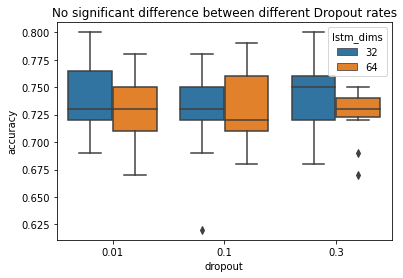

In [ ]:
plt.title('No significant difference between different Dropout rates')
sns.boxplot(data=hyperparameter_df, x='dropout', y='accuracy', hue='lstm_dims')
plt.show()

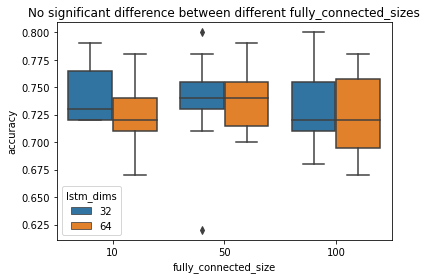

In [67]:
plt.title('No significant difference between different fully_connected_sizes')
sns.boxplot(data=hyperparameter_df, x='fully_connected_size', y='accuracy', hue='lstm_dims')
plt.show()

### Analyse EPOCH = 3 effect on Hyperparameters

Experimentation with different LSTM sizes at Epoch 3 **does not display any differenes wrt accuracy** between selected dimensions [32, 64, 128, 180, 256]

In [69]:
# file will be zipped with submission
hyperparameter_df = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/hyperparameter_df_DEEP_LEARNING_TO_EPOCH_3.csv')

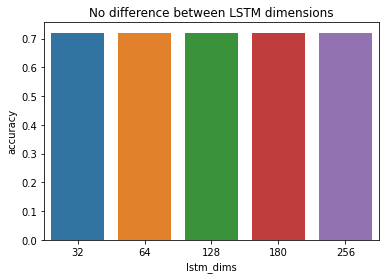

In [70]:
plt.title('No difference between LSTM dimensions')
sns.barplot(data=hyperparameter_df, x='lstm_dims', y='accuracy')
plt.show()